# Data Science Analysis of The Joe Rogan Experience

## Group D
   
   >Simon Chalmers
   >
   >Mitchell Whyte
   >
   >Jack Moore
   
## Introduction

The Joe Rogan Experience is an extremely popular podcast that hosts a variety of different guests. The type of guests and the topics covered on the podcast vary greatly and each guest individually garners a unique reaction from the audience.

## Problem Statement and Goals

Can we predict the ratio of likes to dislikes on youtube videos using youtube video data?

## Our Data

Our data was collected from the Joe Rogan Experience youtube channel through the use of the YouTube data API. We querired the API for video IDs of each episode, we then used these video IDs to query for the statistics, dates and comments which is in JSON format.

The comments were obtained in a seperate file form the video statistics and dates. The comments were then processes through our own custom programmed NLP algorithm to apply a sentiment analysis for each individual comment. The sentiment analysis used a 'Bag of Words' model to evaluate the sentiment of each comment. Each comment was given a numbered label corresponding to which video the comment belonged.

### About the NLP

Each comment is treated as a document and is then broken down into a bagh of words. Each word in the comment is then tokenised using the spaCy python library. Each word is lemmatised to get the root meaning of the word. A list of 144,000 words with sentiments scored attached to them were obtained free from SentiWords, a common method of compaing words to obtain the sentiment. After processing a comment, each word in the bag of words has been given a sentiment score, and the total sentiment score is average of these sentiments. The total magnitude is added up aswell from the sentiment of each word.

After the comments were processed, the sentiment scores and magnitudes were grouped bu tthe video they belonged to. We took the descriptive statistics of the grouped comments for each video and joined it to our dataFrame, along with the other columns of our youtuve video dataFrame.

## Importing Libraries

In [3]:
import json
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt
#import wikipedia
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import re
from pandas.plotting import register_matplotlib_converters
from sklearn.utils import resample
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

## Importing and Cleaning the Data



In [3]:
raw_scores = pd.read_csv('files/raw_scores.csv')
#changed 'data/raw_scores.csv' to 'files/raw_scores_sans_zero_sentiments.csv' - raw_scores.csv aint a thing
#upd8: changed it back to raw_scores
raw_scores = raw_scores.drop(['Unnamed: 0'],axis=1)
print(raw_scores.shape)
raw_scores.head()

(3525956, 3)


,idx,magnitude,sentiment
0,0,18.67,0.06
1,0,14.38,0.35
2,0,48.22,0.07
3,0,32.27,0.25
4,0,61.94,-0.19


The raw_scores dataframe is a dataframe of all the magnitude and sentiment scores for all of our comments. each comment had an idx column entry to associate it to an index of our videos.

In [5]:
len(raw_scores[(raw_scores.magnitude == 0) & (raw_scores.sentiment == 0)])
#i guess we don't need this if the zero sentiments aren't here in the first place?
#nevermind they here now

294856

nearly 300,000 comments with 0 sentiment and 0 magnitude. this is due to them being too short usually. sometimes because the characters were non readable (emojis and such), or spelling mistakes. We remove these from our dataframe

In [6]:
groups = raw_scores.groupby(['idx']).describe()
groups.head()

magnitude                                                              \
        count       mean        std  min     25%     50%      75%     max   
idx                                                                         
0      1714.0  32.058786  28.862256  0.0   8.770  25.645  48.2075  173.46   
1       327.0  36.037951  33.418310  0.0  10.770  28.700  51.5500  187.24   
2       300.0  31.501767  29.066989  0.0   5.295  24.730  50.4400  123.39   
3        59.0  46.788983  47.283555  0.0   9.280  40.060  65.9700  234.21   
4        48.0  35.346667  29.713767  0.0  15.235  27.190  56.1225  132.69   

    sentiment                                                         
        count      mean       std   min     25%    50%     75%   max  
idx                                                                   
0      1714.0  0.175496  0.208130 -0.80  0.0100  0.180  0.3100  0.75  
1       327.0  0.136606  0.220114 -0.64  0.0000  0.150  0.2800  0.72  
2       300.0  0.145467  0.219034 -0.67  0.0000  0.155  0.2800  0.75  
3        59.0  0.102881  0.247387 -0.75  0.0000  0.140  0.2300  0.72  
4        48.0  0.175208  0.227783 -0.34  0.0425  0.155  0.3125  0.68

We group the sentiments and magnitudes according to the column 'idx'. idx represents the video index in the video dataframe. idx = 0 is the first video in the vids dataframe, so all of those sentiments are for all of the comments of videos 0. We append the descriptive stats of the sentiments and magnitudes to the videos dataframe as features to use in our analysis.

In [7]:
vids = pd.read_csv('files/labeled_vids.csv')
vids = vids.drop(['Unnamed: 0','Unnamed: 0.1','sentiment','magnitude'],axis=1)
print(vids.shape)
vids.head()

(1394, 8)


,date,title,class,viewCount,commentCount,likeCount,dislikeCount,ratio
0,2013-01-17,Joe Rogan Experience #1 - Brian Redban,2,673255,2091,6485,175,37.057143
1,2013-01-17,Joe Rogan Experience #2 - Brian Redban,2,134693,359,1004,68,14.764706
2,2013-01-17,Joe Rogan Experience #3 - Ari Shaffir,2,133176,320,1016,66,15.393939
3,2013-01-17,Joe Rogan Experience #5 - Ari Shaffir & John H...,2,49565,59,343,19,18.052632
4,2013-01-18,Joe Rogan Experience #5 - Ari Shaffir & John H...,2,33535,48,278,11,25.272727


In [8]:
null_columns=vids.columns[vids.isnull().any()]
vids[null_columns].isnull().sum()
print(vids[vids.isnull().any(axis=1)][null_columns].head())

Empty DataFrame
Columns: []
Index: []


Checking the data for any null values.

In [9]:
label_list = ['mean','std','min','25%','50%','75%','max']
magnitude_label_list = ['magMean','magStd','magMin','magLq','magMedian','magUq','magMax']
sentiment_label_list = ['sentMean','sentStd','sentMin','sentLq','sentMedian','sentUq','sentMax']
for i,label in enumerate(label_list):
    vids[magnitude_label_list[i]] = groups['magnitude'][label]
    vids[sentiment_label_list[i]] = groups['sentiment'][label]

In [10]:
vids.max()

date                                                   2019-10-01
title           Joe Rogan Experience - UFC Recap w/ Brendan Sc...
class                                                           5
viewCount                                                26071198
commentCount                                               123027
likeCount                                                  530844
dislikeCount                                                86953
ratio                                                         inf
magMean                                                   74.6317
sentMean                                                   0.3175
magStd                                                     70.688
sentStd                                                  0.384282
magMin                                                       37.1
sentMin                                                         0
magLq                                                      38.405
sentLq    

In [11]:
print(vids.iloc[119].ratio)
print(vids.iloc[119].likeCount)
print(vids.iloc[119].dislikeCount)
vids.at[119,'dislikeCount'] = 1
vids.at[119,'ratio'] = 62

inf
62
0


In [12]:
vids.ratio.max()

209.0

We see there is an inf value in our ratio column. We find the culprit and deal with the issue. The issue is that the ratio is derived from dividing the likeCount by the dislikeCount. Any number divided by 0 results in an inf value. This inf value causes problems when analysing the data - many methods do not run if there is an inf value in the column. we deal with this by changing the dislikeCount to 1. No inf value any longer.

In [13]:
vids.iloc[119]

date                                                   2013-01-23
title           Joe Rogan Experience #140 - Brendon Walsh (Par...
class                                                           2
viewCount                                                    5667
commentCount                                                    4
likeCount                                                      62
dislikeCount                                                    1
ratio                                                          62
magMean                                                     14.14
sentMean                                                     0.16
magStd                                                    11.8403
sentStd                                                  0.347563
magMin                                                          0
sentMin                                                     -0.24
magLq                                                      6.6375
sentLq    

In [14]:
vids[vids.title.duplicated()==True]

,date,title,class,viewCount,commentCount,likeCount,dislikeCount,ratio,magMean,sentMean,...,magMin,sentMin,magLq,sentLq,magMedian,sentMedian,magUq,sentUq,magMax,sentMax
763,2016-10-19,Joe Rogan Experience #861 - Bryan Callen,2,520439,1336,4288,525,8.167619,51.650000,0.127004,...,0.0,-0.93,19.4100,0.0000,44.750,0.13,73.0150,0.2600,297.16,0.75
853,2017-04-28,Joe Rogan Experience #952 - Thaddeus Russell,3,529583,6276,3867,9150,0.422623,65.218040,0.129616,...,0.0,-0.80,30.7750,0.0400,56.870,0.14,88.8250,0.2200,390.05,0.84
860,2017-05-10,Joe Rogan Experience #958 - Jordan Peterson,3,4250344,13390,84058,2561,32.822335,56.021853,0.192008,...,0.0,-0.93,21.2400,0.0700,46.150,0.19,77.8700,0.3100,627.62,0.84
1105,2018-11-09,Joe Rogan Experience #1198 - Derren Brown,4,1686086,3555,21589,1076,20.064126,48.186466,0.188513,...,0.0,-0.80,17.1000,0.0500,41.145,0.19,68.9725,0.3200,418.60,0.84
1106,2018-11-13,Joe Rogan Experience #1199 - Tom Segura & Sean...,2,1040899,1624,10737,673,15.953938,46.756941,0.207141,...,0.0,-0.74,15.7200,0.0400,42.100,0.21,71.7175,0.3600,202.45,0.84
1280,2015-10-10,Joe Rogan Experience #706 - Brendan Schaub & F...,1,391579,910,2820,172,16.395349,42.706476,0.146825,...,0.0,-0.80,12.9400,0.0000,34.410,0.14,62.4800,0.2700,290.07,0.81
1281,2015-10-10,Joe Rogan Experience #706 - Brendan Schaub & F...,1,165048,321,1278,72,17.750000,39.894034,0.108824,...,0.0,-0.73,13.1525,-0.0075,32.635,0.11,61.0750,0.2275,174.76,0.75
1341,2018-12-27,JRE MMA Show #53 with Jeff Novitzky,1,1261329,13955,12845,28062,0.457736,51.152850,0.091460,...,0.0,-0.85,20.0400,0.0000,44.970,0.10,74.5700,0.1900,404.02,0.79


In [15]:
print("Shape before removing duplicates: ",vids.shape)
vids = vids[vids.title.duplicated()==False]
print("Shape after removing duplicates: ",vids.shape)

Shape before removing duplicates:  (1394, 22)
Shape after removing duplicates:  (1386, 22)


Because of the way we got our video ID to query the youtube API with, we have some duplicate rows. We remove the duplicated rows from the dataframe.

In [16]:
for col in vids.columns[3:]:
    if str(vids[col].dtype) != 'object':
        vids = vids[(np.abs(stats.zscore(vids[col])) < 3)]
vids = vids[vids['commentCount'] > 100]
vids.index = pd.to_datetime(vids.date)
print("Shape after removing outliers",vids.shape)

Shape after removing outliers (1069, 22)


In [17]:
#6 equally distributed categories of likes/dislikes ratio
bin_labels = [0,1,2,3,4,5]
vids['ratio_bins'] = pd.qcut(vids['ratio'], q=6, labels = bin_labels)

We removed rows where columns were outside of 3 standard deviations. This is to reduce any skewing that might occur from outliers. We also decided to select videos with over 100 comments, because we feel if the amount of comments is too small, then we wont get robust results from the sentiment analysis of the comments. We also created a categorical version of our ratio column, for classification modelling later.

# Data Exploration and Visualisation

## Univariate Analysis

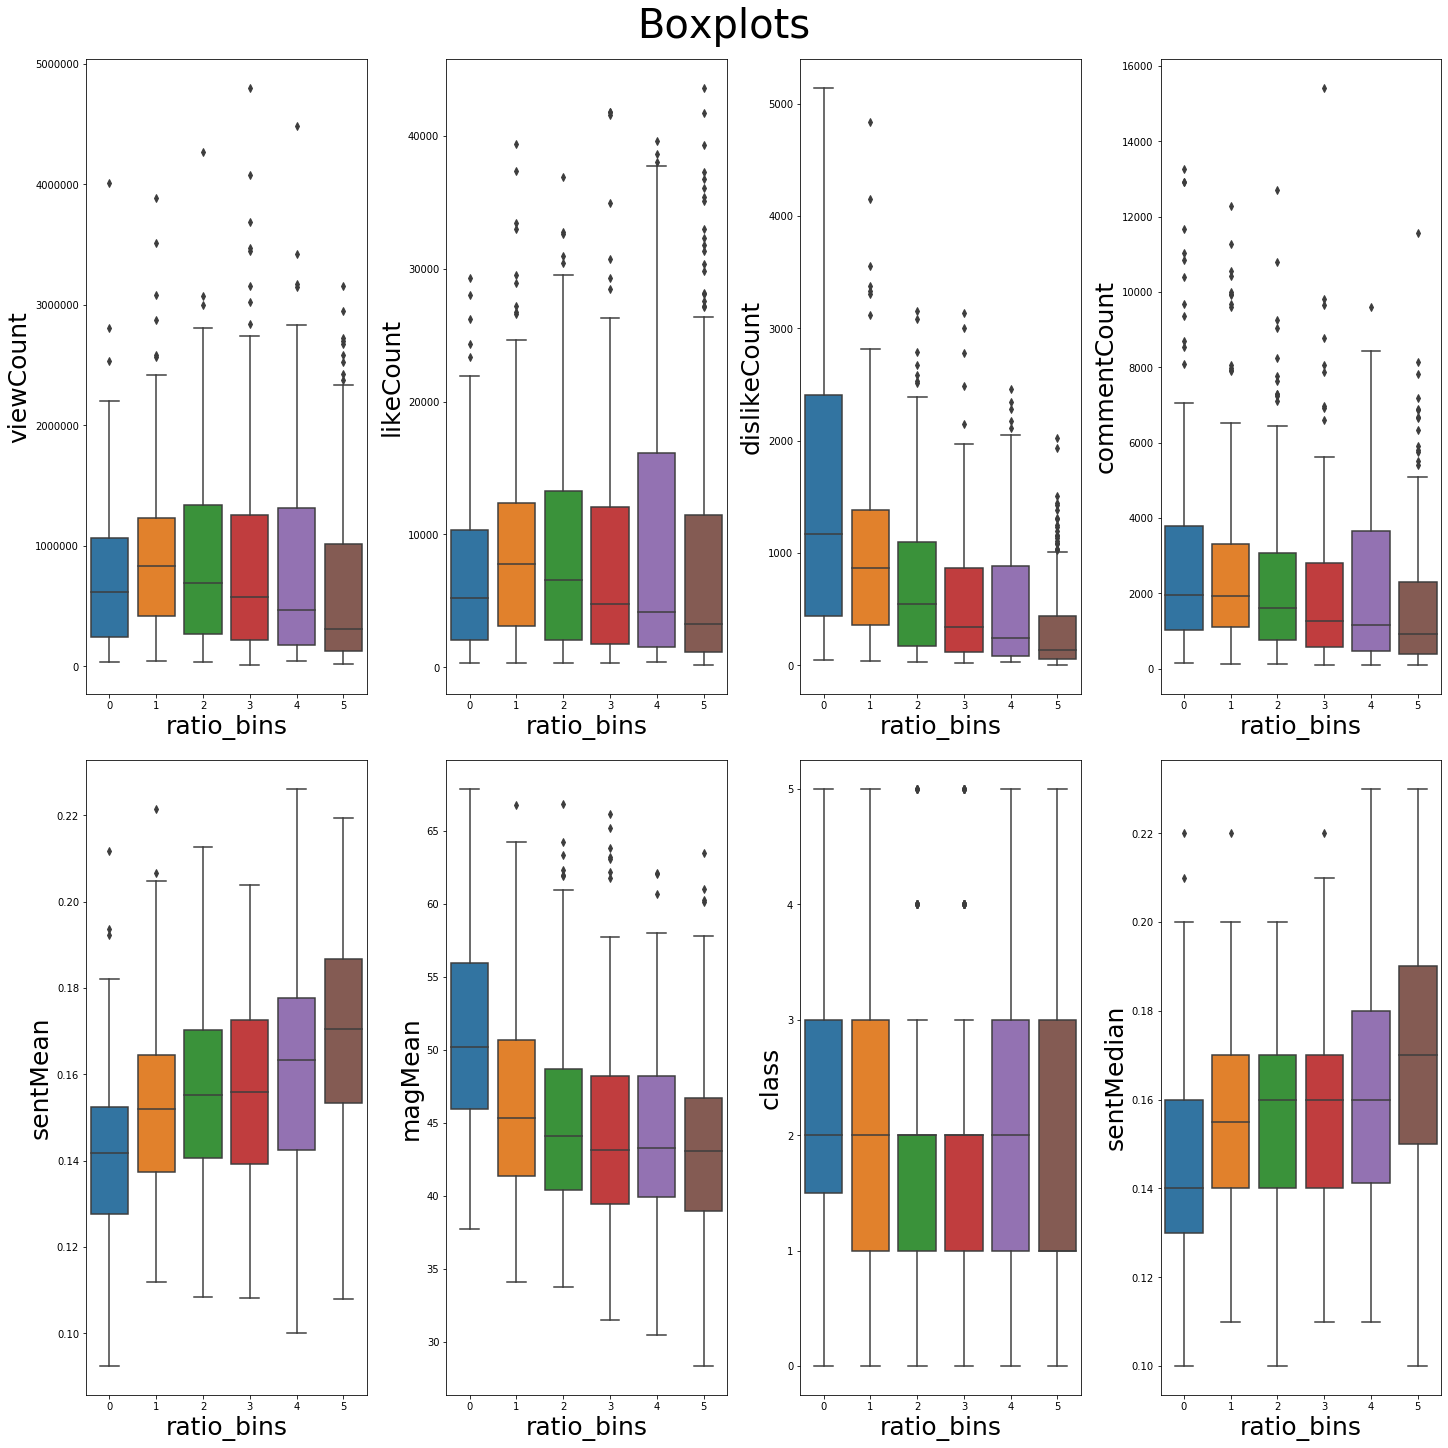

In [18]:
parameters = ['viewCount','likeCount','dislikeCount','commentCount','sentMean','magMean','class','sentMedian']
fig,axes = plt.subplots(2, 4, sharex=False, sharey=False,figsize = (20,20),constrained_layout=True)
plt.suptitle('Boxplots', size='40')
for i, ax in enumerate(axes.flat):
    bp = sns.boxplot(x='ratio_bins',y=parameters[i],data=vids,ax=ax)
    bp.set_ylabel(parameters[i], fontsize=25)
    bp.set_xlabel('ratio_bins', fontsize=25)

We figured boxplots would be the best way to visualise all of our key parameters at once, compared with ratio_bins.  
~~ima have to make that font bigger~~ i made the font bigger
- analysis: maybe comment about: 
       - the like count with category 4
       - the dislike count with category 0
       - maybe add histograms of those two as well?
       - the rest of the data is fairly evently distributed I guess

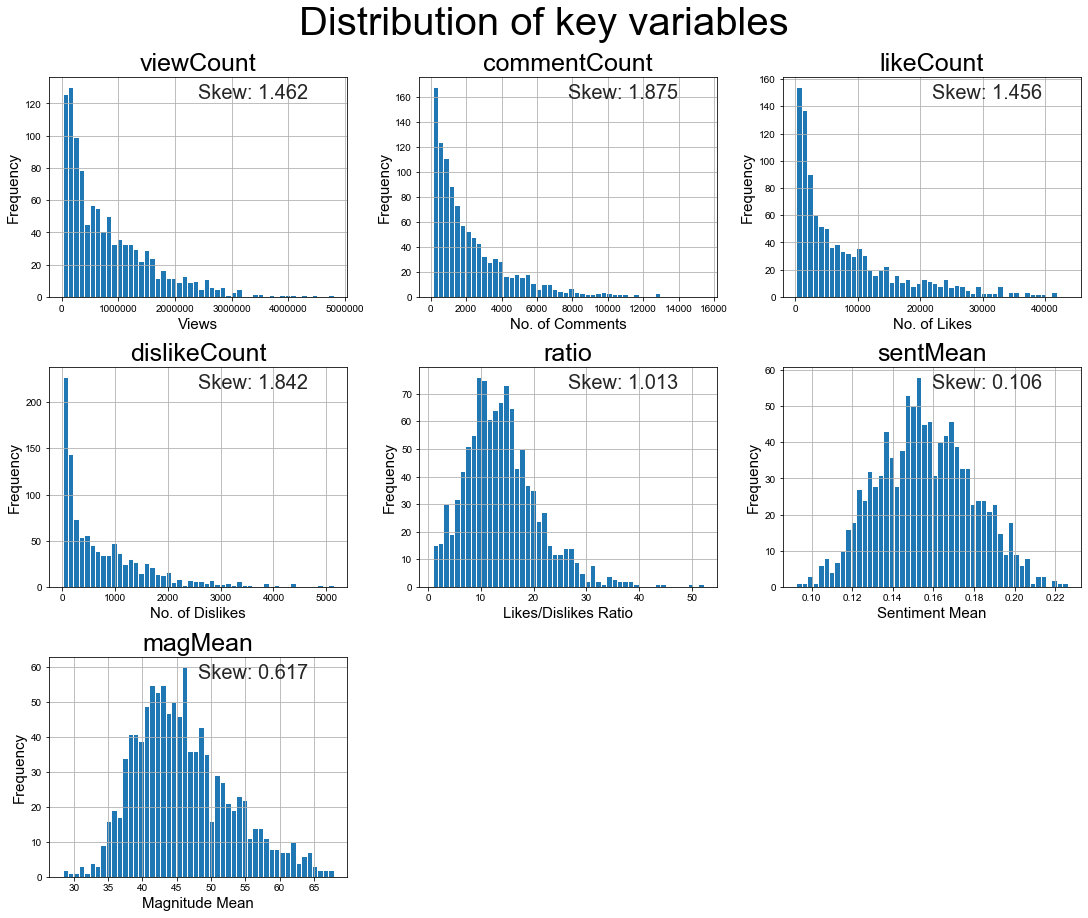

In [19]:
cols = ['viewCount','commentCount','likeCount',
              'dislikeCount','ratio','sentMean',
              'magMean']
x_label_list = ['Views','No. of Comments','No. of Likes','No. of Dislikes',
                'Likes/Dislikes Ratio','Sentiment Mean','Magnitude Mean']

fig,axes = plt.subplots(3, 3, sharex=False, sharey=False,figsize = (15,12),constrained_layout=True)
fig.suptitle('Distribution of key variables', size='40',y=1.05)
sns.set(font_scale=1)
#plt.tight_layout()
fig.delaxes(axes[2][2])
fig.delaxes(axes[2][1])


for i, ax in enumerate(axes.flat):
    if i > 6:
        break
    vids[cols[i]].hist(ax=ax,bins=50)
    skew = ('Skew: ' + str(round(vids[cols[i]].skew(),3)))
    ax.annotate(skew, xy = (0.5, 0.9), size = 20, xycoords = ax.transAxes)
    ax.set_title(cols[i], size=25)
    ax.set_xlabel(x_label_list[i], fontsize=15)
    ax.set_ylabel('Frequency', fontsize=15)

uh  
looks pretty average  
why do we need these again

C:\Users\moste\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


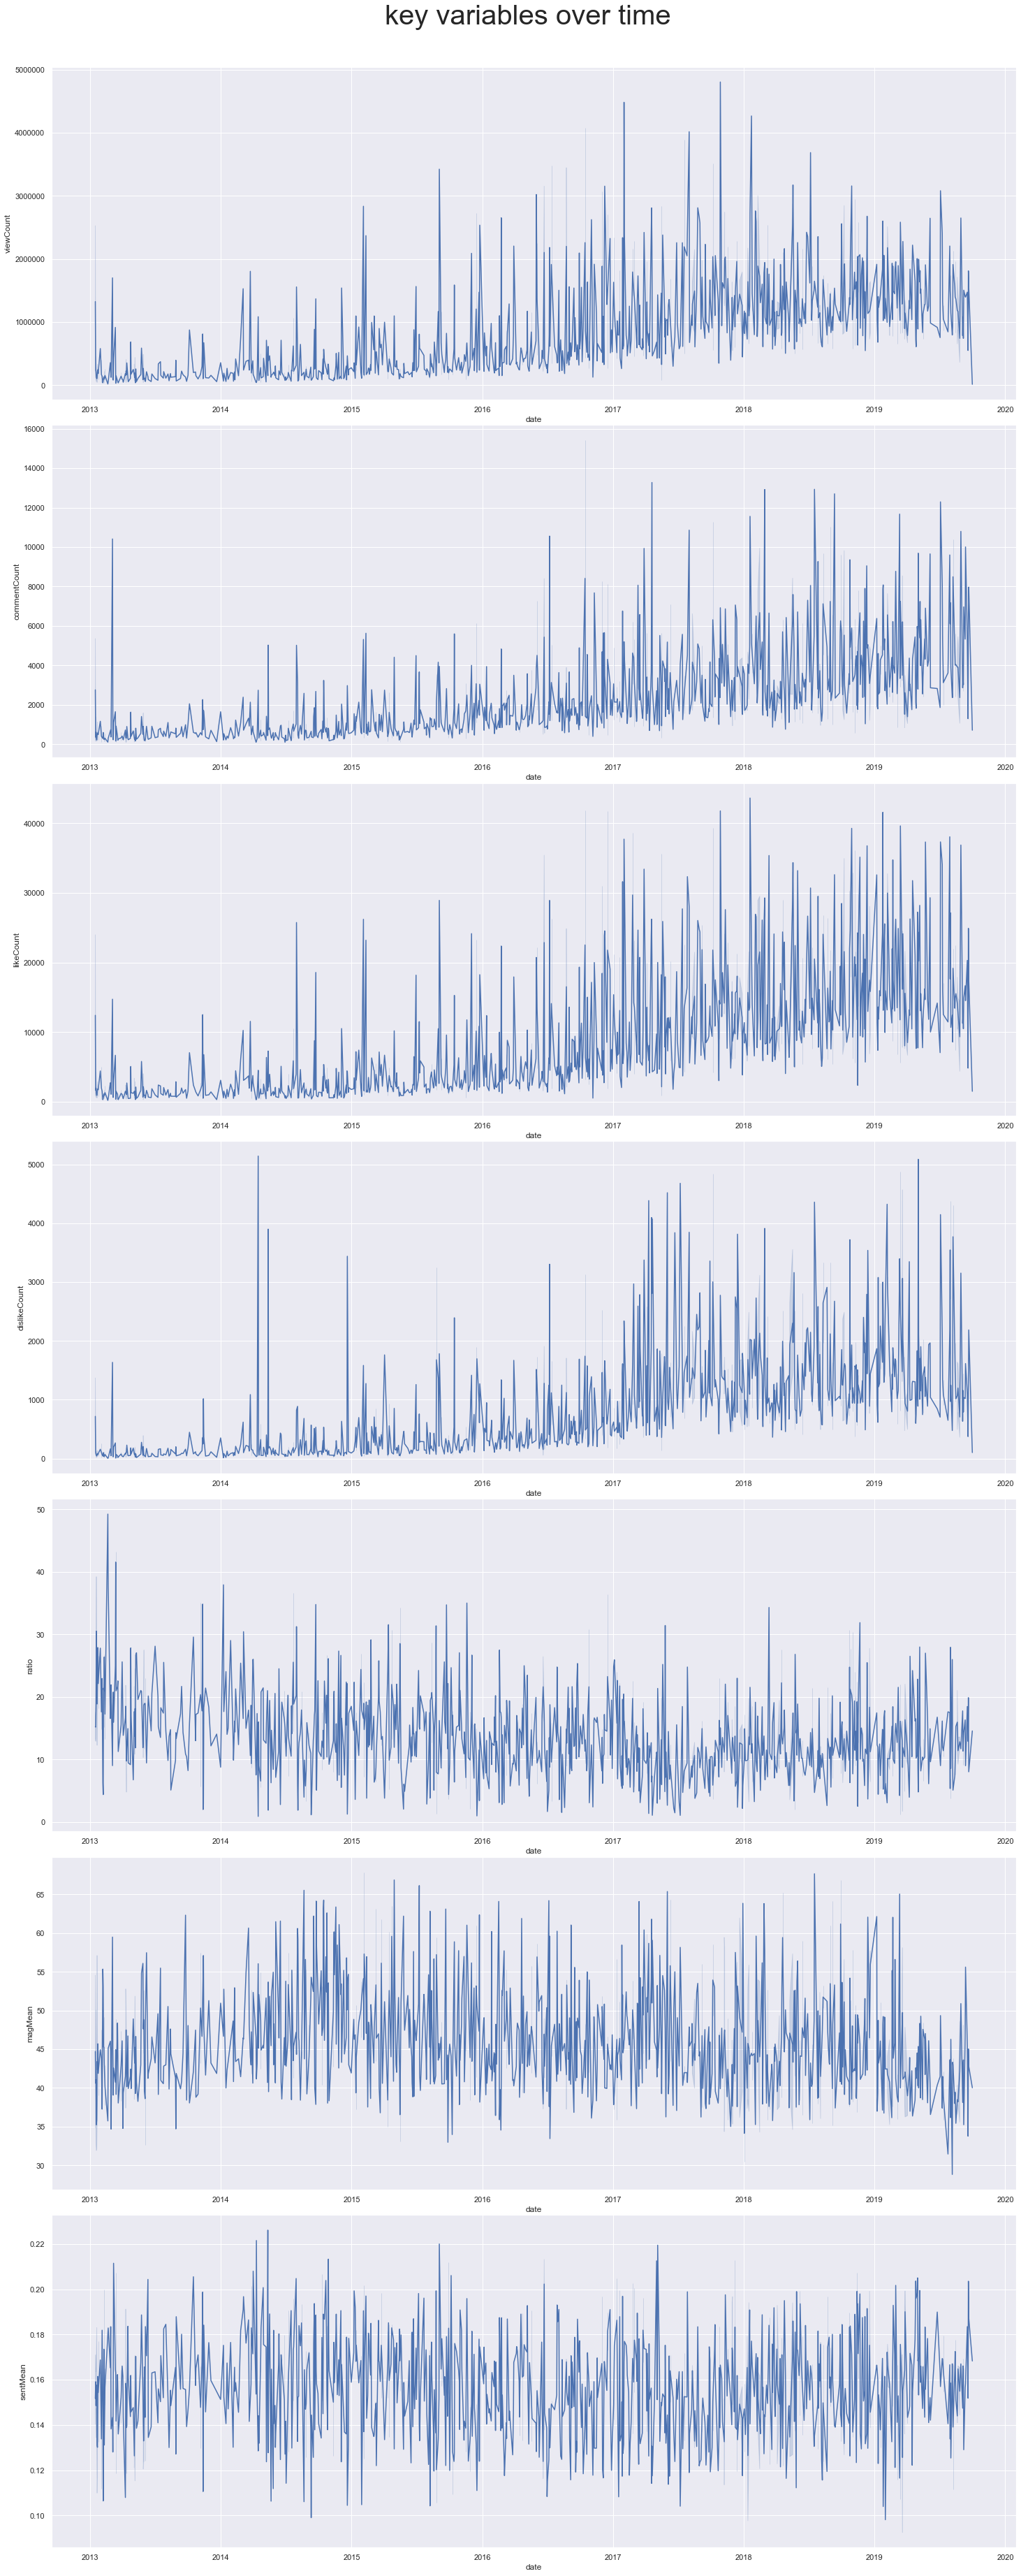

In [20]:
plotting_df=vids
cols = ['viewCount','commentCount','likeCount','dislikeCount','ratio','magMean','sentMean']
titleList = ['views','comment count','likes and dislikes','ratio','magnitude mean','sentiment mean']

fig,axes = plt.subplots(len(cols), 1, sharex=False, sharey=False,figsize = (20,50))
plt.tight_layout()
fig.suptitle('key variables over time', size='40',y=1.02)
for i, ax in enumerate(axes.flat):
    sns.lineplot(data=plotting_df,x=plotting_df.index,y=cols[i],ax=ax)

~~where plotting_df be tho~~ found it i think maybe  
Data was scraped from Jan 15, 2015 to present. 
Slight increase in viewCount and like/dislikeCount from 2017 onwards?

Text(0.5, 1, 'Ratio heatmap with key variables\n')

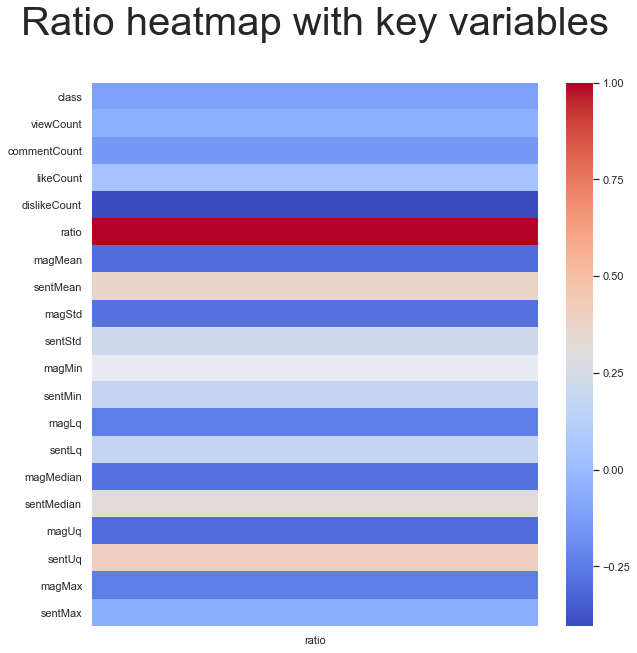

In [21]:
plt.figure(figsize=(10,10))
ratio_correlation = vids.corr().ratio
sns.heatmap(ratio_correlation.to_frame(),cmap = 'coolwarm')
plt.title('Ratio heatmap with key variables\n',size=40)

this heatmap is different to simon's one...

## Bivariate Analysis

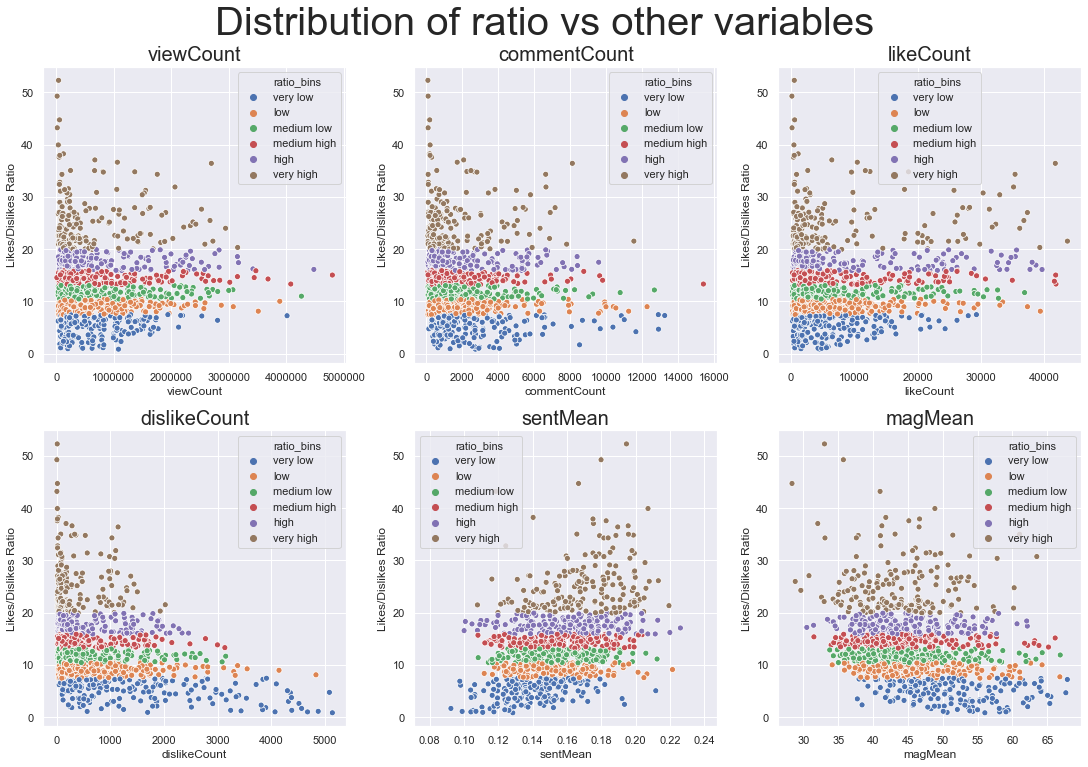

In [22]:
plotting_df = vids
bin_labels = ['very low','low','medium low','medium high','high','very high']
plotting_df['ratio_bins'] = pd.qcut(plotting_df['ratio'], q=6, labels = bin_labels)
#basic visualisation of ratio between sentiment and ratio
fig,axes = plt.subplots(2, 3, sharex=False, sharey=False,figsize = (15,10), constrained_layout=True)

cols = ['viewCount','commentCount','likeCount',
              'dislikeCount','sentMean','magMean']

fig.suptitle('Distribution of ratio vs other variables', size='40',y=1.05)
sns.set(font_scale=1)
#plt.tight_layout()


for i, ax in enumerate(axes.flat):
    sns.scatterplot(data=plotting_df, x=cols[i], y="ratio", hue='ratio_bins',ax=ax)
    ax.set_title(cols[i], size=20)
    ax.set_xlabel(cols[i])
    ax.set_ylabel('Likes/Dislikes Ratio')

Text(0.5, 1.05, 'Pairgrid of key variables\n')

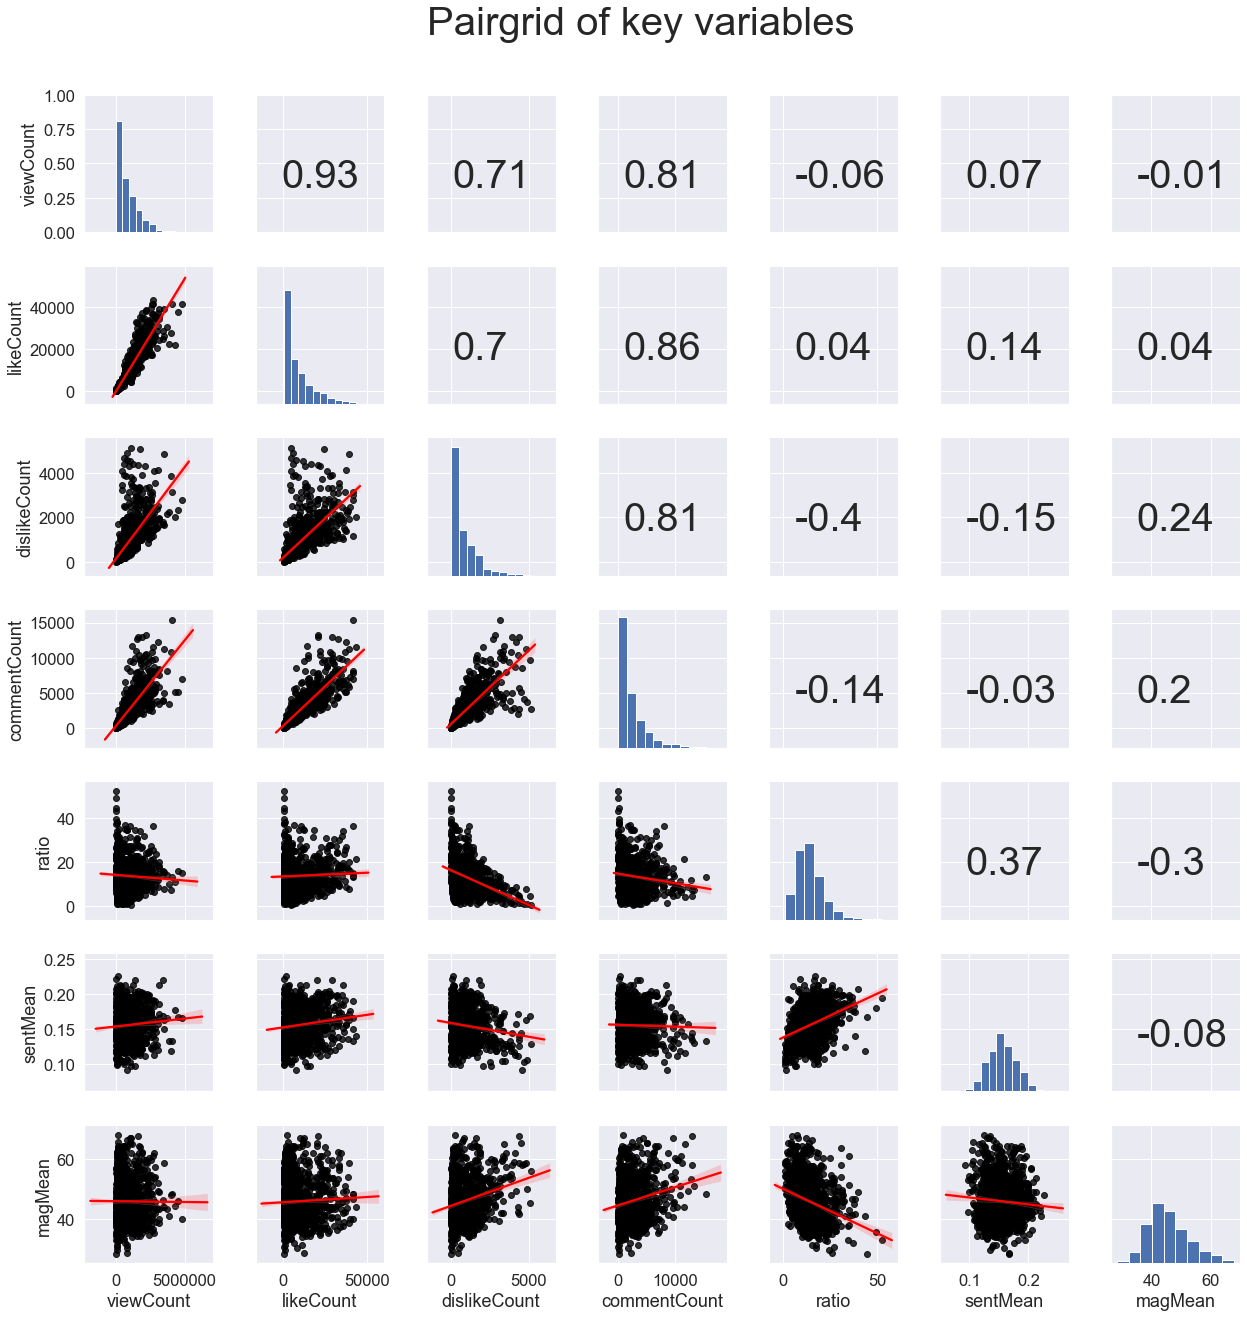

In [23]:
def corr(x, y, **kwargs):
    
    coef = np.corrcoef(x, y)[0][1]
    label = str(round(coef, 2))
    
    ax = plt.gca()
    ax.annotate(label, xy = (0.2, 0.33), size = 40, xycoords = ax.transAxes)
    
params = ['viewCount', 'likeCount', 'dislikeCount', 'commentCount', 'ratio', 'sentMean', 'magMean']

sns.set(font_scale=1.5)
g = sns.PairGrid(vids[params])
g = g.map_lower(sns.regplot,line_kws={"color": "red"}, scatter_kws={'color':'black'})
g = g.map_diag(plt.hist)
g = g.map_upper(corr)
plt.suptitle('Pairgrid of key variables\n',size='40', y=1.05)

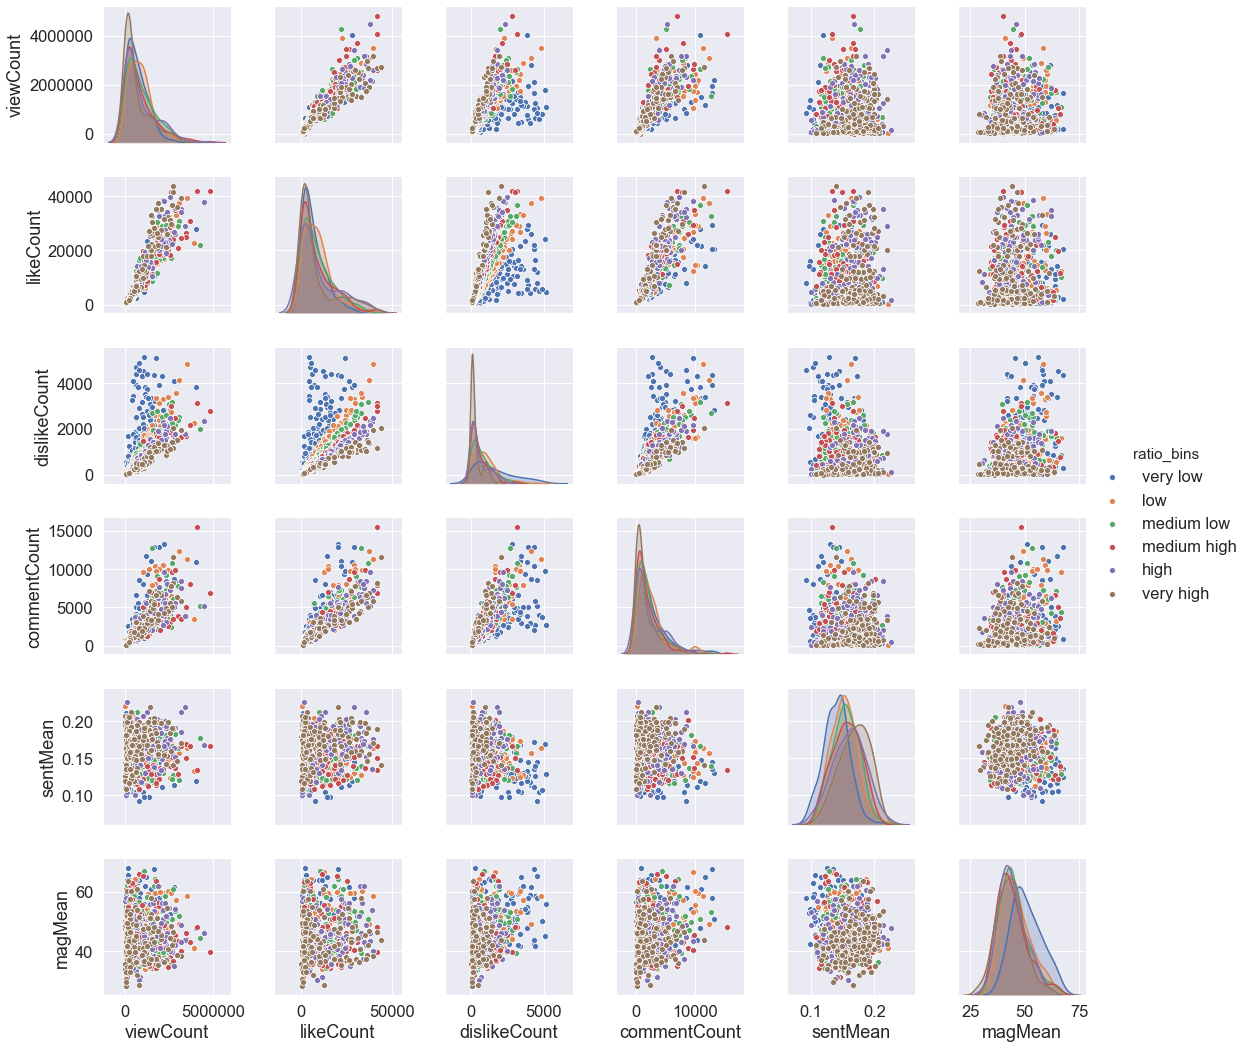

In [24]:
sns.pairplot(vids, vars=['viewCount', 'likeCount', 'dislikeCount', 'commentCount', 'sentMean', 'magMean'], hue='ratio_bins')

not sure if we need this? kind of a mess

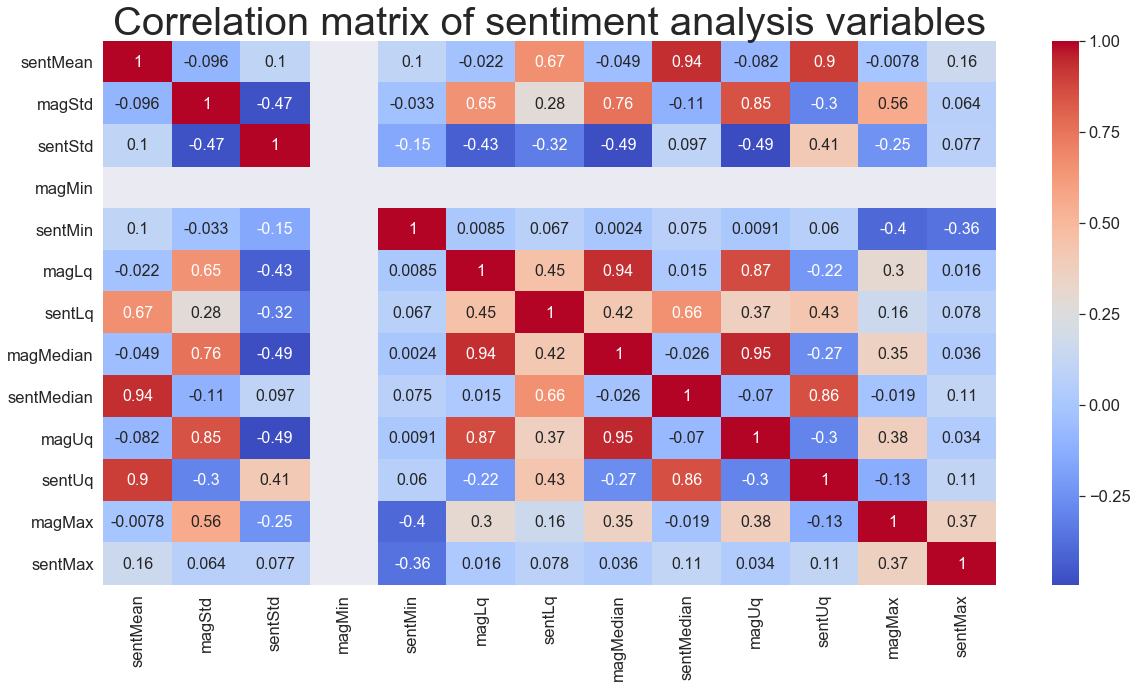

In [25]:
param = vids.columns[9:]
corr = vids[param]
plt.figure(figsize=(20, 10))
plt.title('Correlation matrix of sentiment analysis variables', size=40)
sns.heatmap(corr.corr(), cmap = 'coolwarm', annot = True, annot_kws = {"size":16})

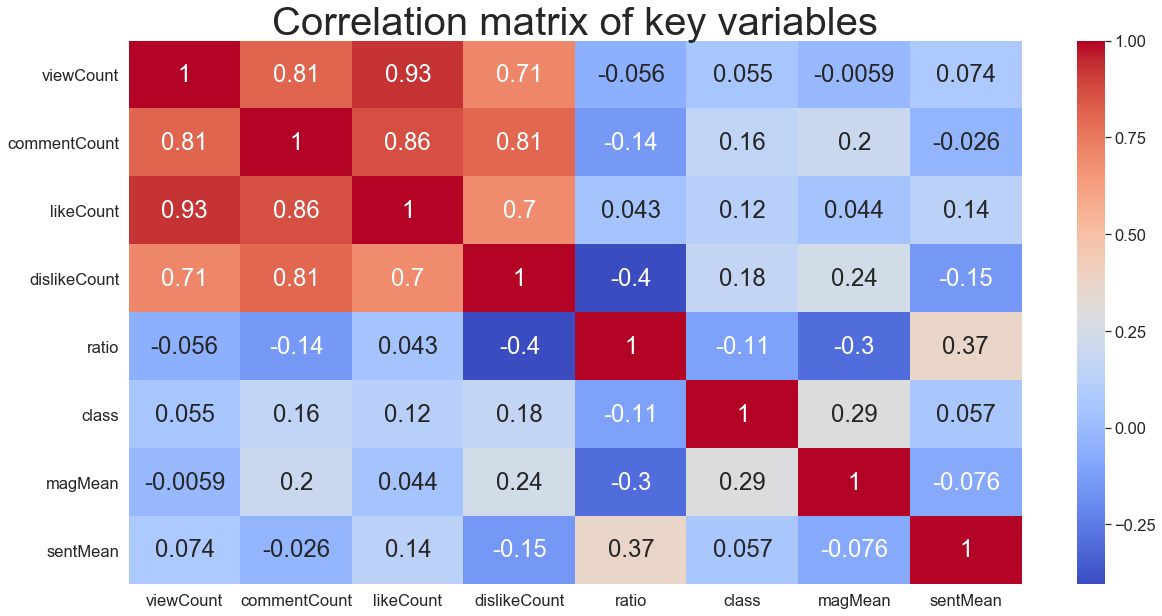

In [26]:
param = ['viewCount','commentCount','likeCount','dislikeCount','ratio','class','magMean','sentMean']
corr = vids[param]

plt.figure(figsize=(20, 10))
plt.title('Correlation matrix of key variables', size=40)

sns.heatmap(corr.corr(), cmap = 'coolwarm', annot = True, annot_kws = {"size":24})

# Data Analysis

## Basic Modelling

For our base modelling, we used linear regression for regression, and logistic regression for classification.  
Basic data preparation:

In [27]:
vids = pd.read_csv('files/df_sans_zero_sentiments.csv')
#filter out outliers with not many comments (not enough comments for sentiment analysis to be robust)
print("dataframe before filtering: ",vids.shape)
for col in vids.columns[3:]:
    if str(vids[col].dtype) != 'object':
        vids = vids[(np.abs(stats.zscore(vids[col])) < 3)]
vids = vids[vids['commentCount'] > 100]
vids = vids.drop(['Unnamed: 0'],axis=1)
vids.index = pd.to_datetime(vids.date)
#6 equally distributed categories of likes/dislikes ratio
bin_labels = [0,1,2,3,4,5]
vids['ratio_bins'] = pd.qcut(vids['ratio'], q=6, labels = bin_labels)
print("dataframe shape after filtering outliers and low comment rows: ",vids.shape)
vids = vids[vids.title.duplicated()==False]
print("dataframe shape after removing duplicates",vids.shape)

dataframe before filtering:  (1394, 23)
dataframe shape after filtering outliers and low comment rows:  (1088, 23)
dataframe shape after removing duplicates (1083, 23)


In [28]:
drop_parameters = ['date','title','ratio','ratio_bins','likeCount','dislikeCount']
X = vids.drop(drop_parameters,axis=1)
y = vids['ratio_bins']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=42)

In [29]:
X_train.shape

(866, 17)

## Linear Regression

For our linear regression model, we used Linear Regression along with Recursive Feature Elimination for our prediction.

In [30]:
predictions = []
for i in range(1, 18):
    estimator = linear_model.LinearRegression()
    selector = RFE(estimator, i)
    selector.fit(X_train,y_train)
    predictions.append(selector.predict(X_test))

In [31]:
mse, rmse, rsquared, mae = ([] for i in range(4))
for prediction in predictions:
    mse.append(mean_squared_error(y_test, prediction))
    rmse.append(np.sqrt(mean_squared_error(y_test, prediction)))
    rsquared.append(r2_score(y_test, prediction))
    mae.append(mean_absolute_error(y_test, prediction))
prediction_df = pd.DataFrame(
    {'mse': mse,
     'rmse': rmse,
    'rsquared': rsquared,
     'mae': mae
    })

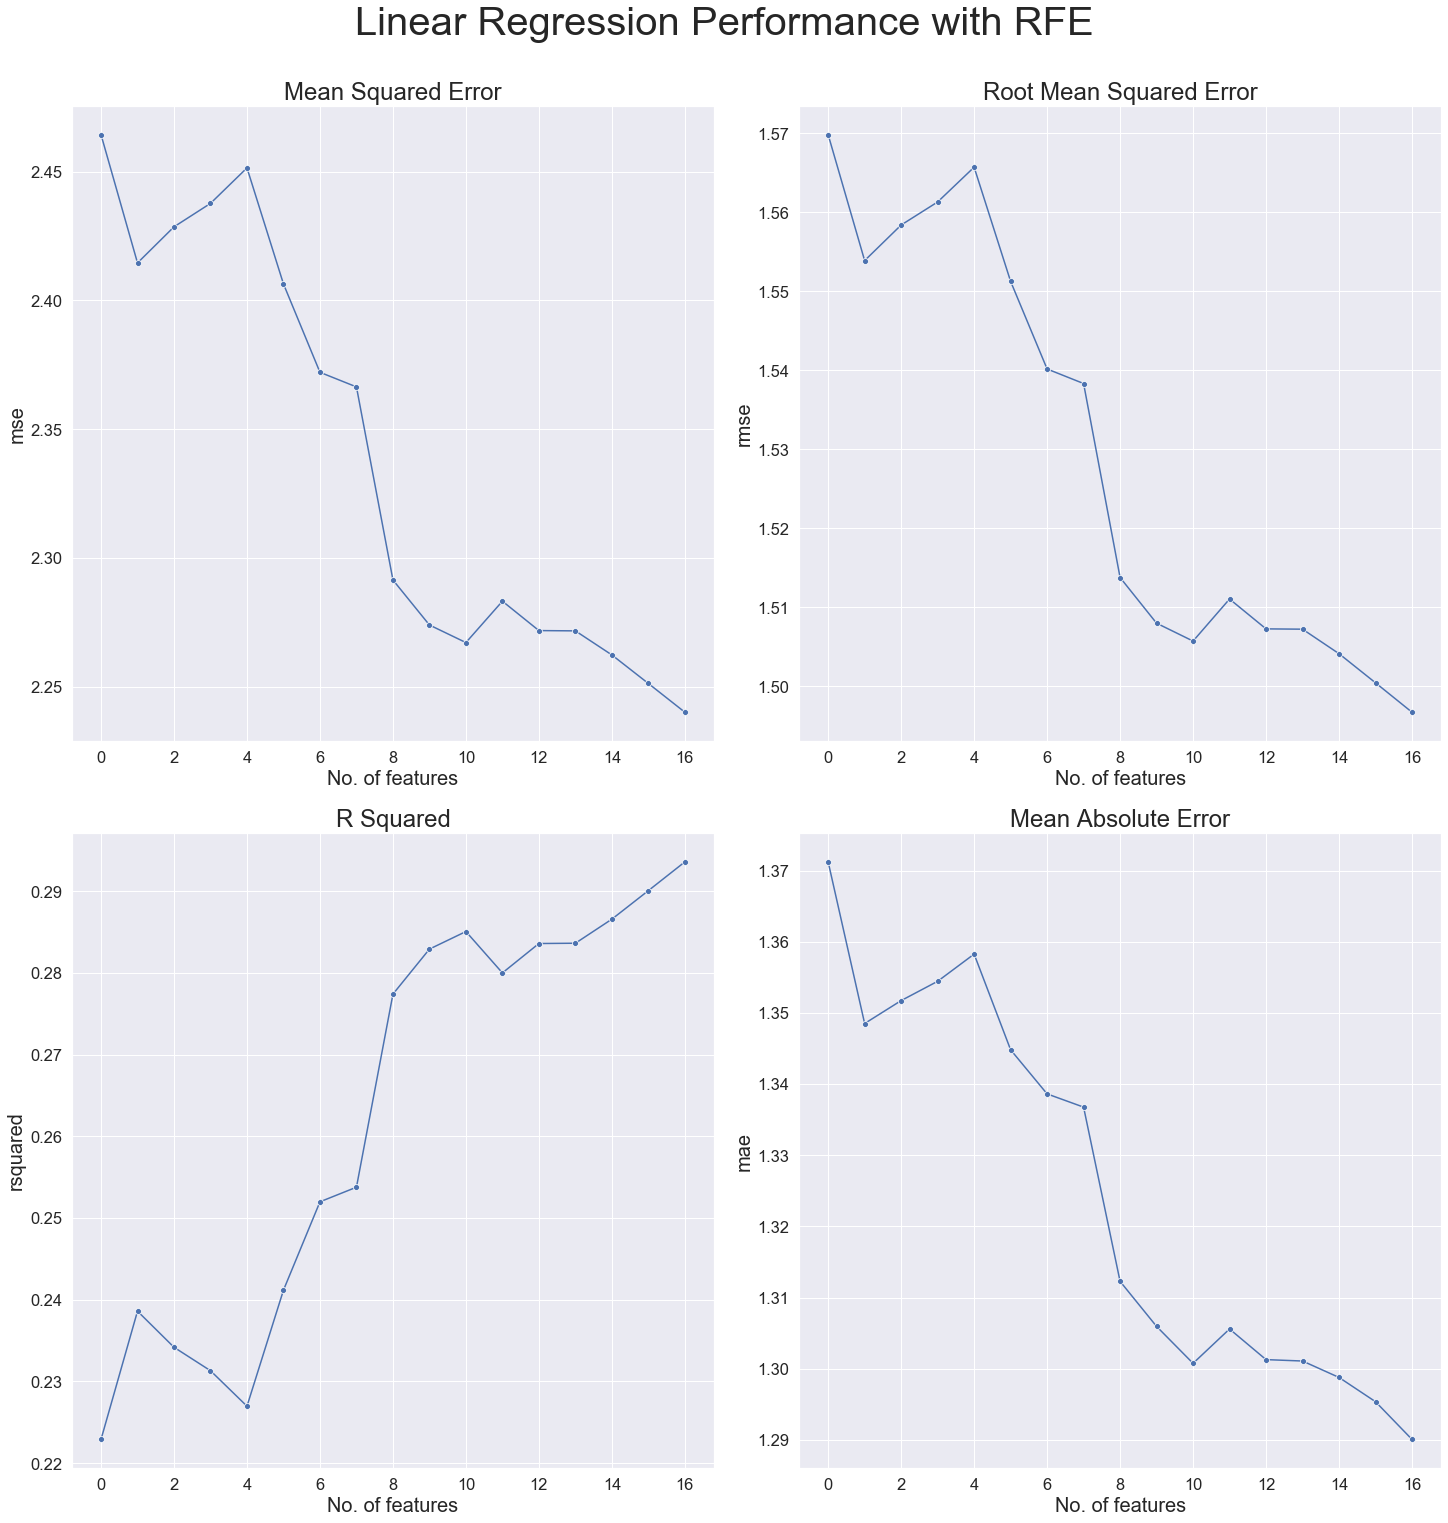

In [32]:
cols = ['mse','rmse','rsquared','mae']
titleList = ['Mean Squared Error','Root Mean Squared Error','R Squared','Mean Absolute Error']

fig,axes = plt.subplots(2, 2, sharex=False, sharey=False,figsize = (20,20),constrained_layout = True)
#plt.tight_layout()
fig.suptitle('Linear Regression Performance with RFE', size='40',y=1.05)
for i, ax in enumerate(axes.flat):
    sns.lineplot(data=prediction_df,x=prediction_df.index,y=cols[i],ax=ax,marker="o")
    ax.set_title(titleList[i],size='24')
    ax.set_xlabel('No. of features',size='20')
    ax.set_ylabel(cols[i],size='20')

In [33]:
drop_parameters = ['date','title','ratio','ratio_bins']
X = vids.drop(drop_parameters,axis=1)
y = vids['ratio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=42)
estimator = linear_model.LinearRegression()
selector = RFE(estimator,1)
selector.fit(X_train, y_train)
prediction = selector.predict(X_test)
selector.ranking_

array([ 9, 19, 18, 17, 16, 12, 11,  8, 10, 13, 14, 15,  1,  2,  7,  4,  3,
        5,  6])

In [34]:
feature_rankings = pd.DataFrame(
    {'features': X_train.columns,
     'ranking': selector.ranking_})
feature_rankings.sort_values(by=['ranking'])

,features,ranking
12,sentMean,1
13,sentStd,2
16,sentMedian,3
15,sentLq,4
17,sentUq,5
18,sentMax,6
14,sentMin,7
7,magMin,8
0,class,9
8,magLq,10


We see that the linear regression performs the best with all of the features. We observe the ranking of importance of these features.

## Logistic Regression

For our logistic regression model, we used Logistic Regression along with Recursive Feature Elimination again.

In [35]:
drop_parameters = ['date','title','ratio','ratio_bins','dislikeCount','likeCount','commentCount','viewCount','magMax']
X = vids.drop(drop_parameters,axis=1)
y = vids['ratio_bins']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=42)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
predicted = logreg.predict(X_test)
print(accuracy_score(y_test,predicted))
print(f1_score(y_test,predicted,average='macro'))
print(recall_score(y_test,predicted,average='macro'))
print(precision_score(y_test,predicted,average='macro'))
print(confusion_matrix(y_test,predicted))

#need to specify the solver

0.3456221198156682
0.2984910519791342
0.33667054548019043
0.27660776563589856
[[26  4  6  0  3  2]
 [ 9  6  8  1  4  6]
 [ 2  4 16  0  3  6]
 [ 5  3 13  0  7  7]
 [ 5  6  6  1  9  7]
 [ 8  2  6  0  8 18]]


C:\Users\moste\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\moste\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [36]:
predictions = []
for i in range(1, 20):
    estimator = LogisticRegression()
    selector = RFE(estimator, i)
    selector.fit(X_train,y_train)
    predictions.append(selector.predict(X_test))
    
#need to specify multi_class and solver

C:\Users\moste\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\moste\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\moste\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\moste\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\moste\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default so

C:\Users\moste\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\moste\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\moste\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\moste\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\moste\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default mu

C:\Users\moste\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\moste\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\moste\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\moste\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\moste\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default mu

C:\Users\moste\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\moste\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\moste\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\moste\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\moste\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default mu

C:\Users\moste\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\moste\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\moste\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\moste\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\moste\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default so

In [37]:
accuracy, f1, recall, precision = ([] for i in range(4))
for prediction in predictions:
    accuracy.append(accuracy_score(y_test,prediction))
    f1.append(f1_score(y_test,prediction,average='macro'))
    recall.append(recall_score(y_test,prediction,average='macro'))
    precision.append(precision_score(y_test,prediction,average='macro'))
    
prediction_df = pd.DataFrame(
    {'accuracy': accuracy,
     'f1': f1,
    'recall': recall,
     'precision': precision
    })

C:\Users\moste\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\moste\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


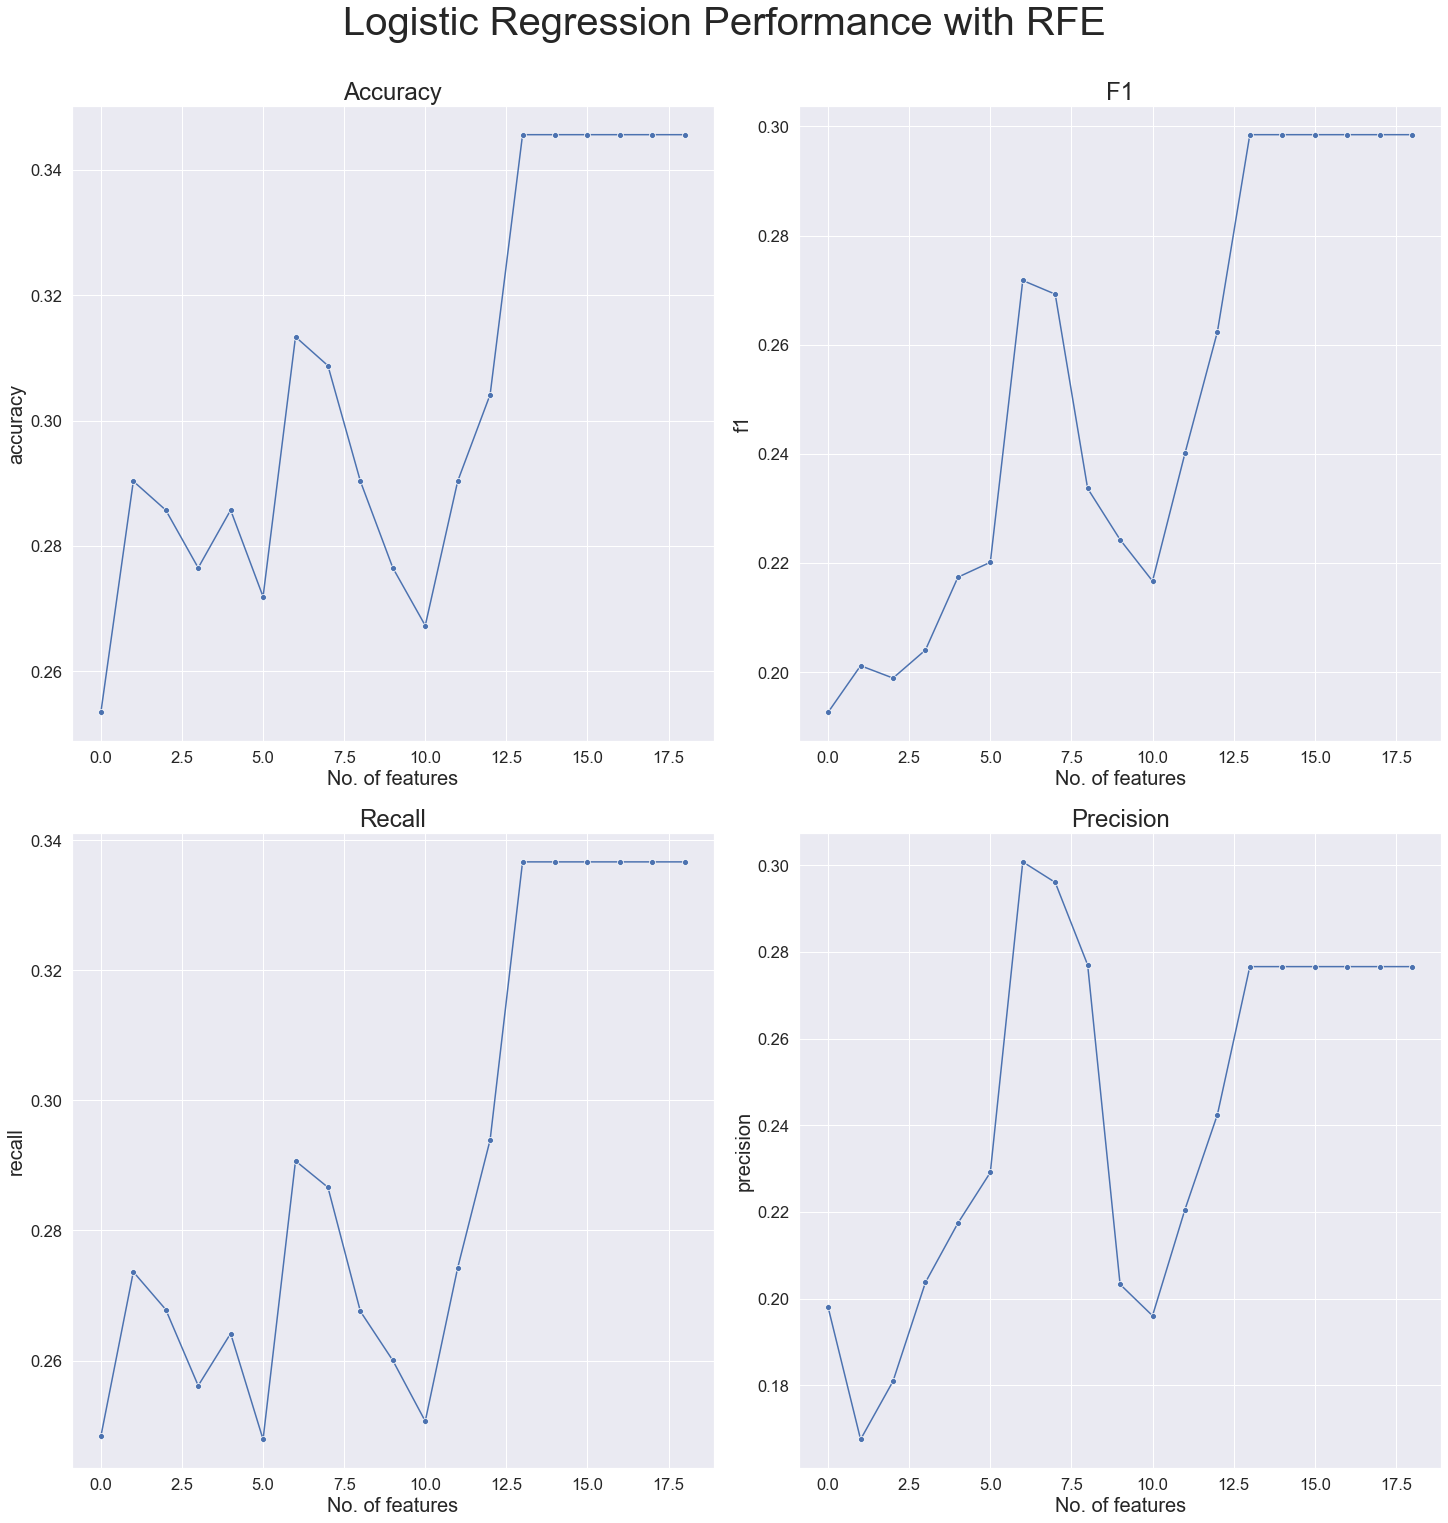

In [38]:
cols = ['accuracy','f1','recall','precision']
titleList = ['Accuracy','F1','Recall','Precision']

fig,axes = plt.subplots(2, 2, sharex=False, sharey=False,figsize = (20,20),constrained_layout = True)
#plt.tight_layout()
fig.suptitle('Logistic Regression Performance with RFE', size='40',y=1.05)
for i, ax in enumerate(axes.flat):
    sns.lineplot(data=prediction_df,x=prediction_df.index,y=cols[i],ax=ax,marker="o")
    ax.set_title(titleList[i],size='24')
    ax.set_xlabel('No. of features',size='20')
    ax.set_ylabel(cols[i],size='20')

In [39]:
estimator = LogisticRegression(multi_class='auto', solver='liblinear')
selector = RFE(estimator, 1)
selector.fit(X_train,y_train)

RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                 fit_intercept=True, intercept_scaling=1,
                                 l1_ratio=None, max_iter=100,
                                 multi_class='auto', n_jobs=None, penalty='l2',
                                 random_state=None, solver='liblinear',
                                 tol=0.0001, verbose=0, warm_start=False),
    n_features_to_select=1, step=1, verbose=0)

In [40]:
feature_rankings = pd.DataFrame(
    {'features': X_train.columns,
     'ranking': selector.ranking_})
feature_rankings.sort_values(by=['ranking'])

,features,ranking
12,sentUq,1
7,sentMean,2
9,sentMin,3
11,sentMedian,4
10,sentLq,5
13,sentMax,6
3,magMin,7
8,sentStd,8
4,magLq,9
2,magStd,10


# Improved Modelling

For our improved modelling, we used RandomForestRegressor for regression, and SVC, RandomForestClassifier and DecisionTree for classification. They were all run through GridSearchCV in order to find the best combination of parameters for the best training and testing result possible. 

## Linear Regression
### RandomForestRegressor

In [12]:
vids = pd.read_csv('files/df_sans_zero_sentiments.csv')
#filter out outliers with not many comments (not enough comments for sentiment analysis to be robust)
print("dataframe before filtering: ",vids.shape)
for col in vids.columns[3:]:
    if str(vids[col].dtype) != 'object':
        vids = vids[(np.abs(stats.zscore(vids[col])) < 3)]
vids = vids[vids['commentCount'] > 100]
vids = vids.drop(['Unnamed: 0'],axis=1)
vids.index = pd.to_datetime(vids.date)
#6 equally distributed categories of likes/dislikes ratio
bin_labels = [0,1,2,3,4,5]
vids['ratio_bins'] = pd.qcut(vids['ratio'], q=6, labels = bin_labels)
print("dataframe shape after filtering outliers and low comment rows: ",vids.shape)
vids = vids[vids.title.duplicated()==False]
print("dataframe shape after removing duplicates",vids.shape)

dataframe before filtering:  (1394, 23)
dataframe shape after filtering outliers and low comment rows:  (1088, 23)
dataframe shape after removing duplicates (1083, 23)


Importing data again to ensure lack of inconsistencies.

In [13]:
drop_parameters = ['date','title','ratio','ratio_bins','dislikeCount','likeCount']
X = vids.drop(drop_parameters,axis=1)
y = vids['ratio_bins']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=42)

Dropping parameters that would dilute the result of the training/testing.

In [14]:
predictions = []
for i in range(1, 18):
    estimator = linear_model.LinearRegression()
    selector = RFE(estimator, i)
    selector.fit(X_train,y_train)
    predictions.append(selector.predict(X_test))

In [15]:
r2_score(y_test,predictions[17])
#idk why this aint working

IndexError: list index out of range

In [16]:
r2_list = []
for i in range(1, 18):
    print(i)
    estimator = RandomForestRegressor(n_estimators=500, n_jobs=-1,random_state=42)
    selector = RFE(estimator, i)
    selector.fit(X_train,y_train)
    predicted = selector.predict(X_test)
    r2_list.append(r2_score(y_test, predicted))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


In [17]:
r2_list

[-0.14576580100448688,
 0.2422635460523671,
 0.2938421427978303,
 0.3039976672336435,
 0.361583663322842,
 0.3803112995379361,
 0.3847719348556887,
 0.36418395486506383,
 0.3640631509810487,
 0.36690493403870617,
 0.3709570170494877,
 0.362802478778544,
 0.36581779789727453,
 0.3649053196544565,
 0.3895067693564589,
 0.39582246476930294,
 0.3986110506395232]

In [18]:
from joblib import dump, load
dump(grid_searches[0].best_estimator_, 'files/joblibs/decisiontree.joblib',compress=1)
dump(grid_searches[1].best_estimator_, 'files/joblibs/randomforestclassifier.joblib',compress=1)

clf = load('decisiontree.joblib')

IndexError: list index out of range

In order for us to avoid rerunning large computations numerous times, we used `joblib` to store our computed data for future use.  
where grid_searches tho

In [ ]:
test = dump(grid_searches[0], 'files/joblibs/gridobj1.joblib',compress=1)

In [ ]:
test = load('files/joblibs/gridobj1.joblib')

In [ ]:
test.best_score_

In [ ]:
test = load('files/joblibs/svc_grid.joblib')

In [ ]:
y_pred = test.predict(X_test.drop(['viewCount','magMax','commentCount'],axis=1))
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('F1: ', f1_score(y_test, y_pred, average='macro'))
print('Precision: ', precision_score(y_test, y_pred, average='macro'))
print('Recall: ', recall_score(y_test, y_pred, average='macro'))
print(confusion_matrix(y_test, y_pred))

In [ ]:
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('F1: ', f1_score(y_test, y_pred, average='macro'))
print('Precision: ', precision_score(y_test, y_pred, average='macro'))
print('Recall: ', recall_score(y_test, y_pred, average='macro'))
print(confusion_matrix(y_test, y_pred))

## Classification

In [19]:
#already have a good scv with good parameters
models = [DecisionTreeClassifier(random_state=42),RandomForestClassifier(random_state=42)]
params = [dict(criterion=['gini','entropy'],splitter=['best','random'],max_depth=[None,3,5,6],max_features=[None,2,4,6,8,10,12,14,15,16,17]),
          dict(min_samples_leaf=[50,1],n_estimators=[50,100,500],max_features=[None,2,4,6,8,10,12,14,15,16,17])]

grid_searches = []

for model,param in zip(models,params):
    grid_search = GridSearchCV(estimator=model, param_grid=param, cv=10, scoring='accuracy',n_jobs=-1,verbose=2)
    grid_searches.append(grid_search.fit(X_train,y_train))

Fitting 10 folds for each of 176 candidates, totalling 1760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 1760 out of 1760 | elapsed:    5.2s finished
C:\Users\moste\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 10 folds for each of 66 candidates, totalling 660 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 170 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 373 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 660 out of 660 | elapsed:  1.2min finished
C:\Users\moste\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [ ]:
# # doesn't run

# rbf = {'kernel': ['rbf'], 'gamma': [0.1, 0.01, 0.001, 0.0001],
#  'C': [0.001, 0.01, 0.1, 1, 10, 100, 100]}
# linear = {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}
# param = [linear, rbf]

# grid_search = GridSearchCV(estimator=SVC(random_state=42), param_grid=param,
#                          cv=2, scoring='accuracy',verbose=4,n_jobs=-1)

# grid_search.fit(X_train, y_train)

# grid_searches.append(grid_search.fit(X_train, y_train))

Fitting 2 folds for each of 34 candidates, totalling 68 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [4]:
for i in range(len(grid_searches)):
    clf = grid_searches[i].best_estimator_
    #print('best clf:', clf)
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('F1: ', f1_score(y_test, y_pred, average='macro'))
    print('Precision: ', precision_score(y_test, y_pred, average='macro'))
    print('Recall: ', recall_score(y_test, y_pred, average='macro'))
    print(confusion_matrix(y_test, y_pred))

NameError: name 'grid_searches' is not defined

In [5]:
gs = GridSearchCV(
        estimator=RandomForestRegressor(random_state=42),
        param_grid={
            'max_depth': [3, None],
            'n_estimators': (100,200,400,600,800,1000),
            'max_features': (2,6,10,12,15,16,17)
        }, cv=10, n_jobs=-1, scoring='r2',verbose=2
    )
model = gs.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [6]:
svc = SVC(random_state=42)
result = svc.fit(X_train.drop(['viewCount','magMax','commentCount'],axis=1),y_train)

NameError: name 'X_train' is not defined

In [7]:
predict = result.predict(X_test.drop(['viewCount','magMax','commentCount'],axis=1))
accuracy_score(y_test,predict)

NameError: name 'result' is not defined

## Other Model

## Improved Models Compared to Basic Models

# Summary and Future Improvement

# Conclusion